# 16. RAG Evaluation with RAGAS Framework

**Complexity:** ⭐⭐⭐⭐

## Overview

**RAGAS** (RAG Assessment) is a comprehensive framework for evaluating Retrieval-Augmented Generation systems. It provides metrics to measure both retrieval quality and generation quality.

### Why Evaluation Matters

Without evaluation, you can't:
- ❌ Compare different RAG architectures objectively
- ❌ Track improvements over time
- ❌ Identify weak points in your system
- ❌ Justify architectural choices
- ❌ Optimize for production

### RAGAS Metrics

RAGAS provides 6 key metrics:

1. **Faithfulness** (0-1): Is the answer grounded in retrieved context?
   - Measures hallucination
   - Higher = less hallucination

2. **Answer Relevancy** (0-1): Is the answer relevant to the question?
   - Measures if answer addresses the query
   - Higher = more relevant

3. **Context Precision** (0-1): Are retrieved documents relevant?
   - Measures retrieval precision
   - Higher = less noise

4. **Context Recall** (0-1): Did retrieval find all relevant info?
   - Measures retrieval completeness
   - Requires ground truth

5. **Answer Semantic Similarity** (0-1): Similarity to reference answer
   - Measures correctness
   - Requires ground truth answer

6. **Answer Correctness** (0-1): Factual accuracy vs ground truth
   - Weighted F1 score
   - Requires ground truth

### Evaluation Dataset

For each test case, you need:
```python
{
    "question": "What is LCEL?",
    "answer": "<generated answer>",
    "contexts": ["<retrieved doc 1>", "<retrieved doc 2>", ...],
    "ground_truth": "LCEL is LangChain Expression Language..."  # optional
}
```

### Architecture Comparison

We'll evaluate all 12 RAG architectures:
1. Simple RAG
2. RAG with Memory
3. Multi-Query RAG
4. HyDE
5. Adaptive RAG
6. Corrective RAG
7. Self-RAG
8. Agentic RAG
9. **Contextual RAG** [NEW]
10. **Fusion RAG** [NEW]
11. **SQL RAG** [NEW]
12. **GraphRAG** [NEW]

---

## Implementation

## 1. Setup and Imports

In [12]:
import sys
from pathlib import Path
from typing import Dict, Any
import pandas as pd

# Add parent directory to path
sys.path.append(str(Path("../..").resolve()))

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# RAGAS imports
try:
    from ragas import evaluate
    from ragas.metrics import (
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
    )
    from datasets import Dataset
    RAGAS_AVAILABLE = True
except ImportError:
    print("⚠️  RAGAS not installed. Install with: pip install ragas datasets")
    RAGAS_AVAILABLE = False

from shared.config import (
    verify_api_key,
    DEFAULT_MODEL,
    DEFAULT_TEMPERATURE,
    OPENAI_EMBEDDING_MODEL,
    VECTOR_STORE_DIR,
)
from shared.loaders import load_and_split
from shared.prompts import RAG_PROMPT_TEMPLATE
from shared.utils import (
    format_docs,
    print_section_header,
    load_vector_store,
)

# Verify API key
verify_api_key()

print("✓ All imports successful")
print(f"✓ Using model: {DEFAULT_MODEL}")
print(f"✓ RAGAS available: {RAGAS_AVAILABLE}")

✓ OpenAI API Key: LOADED
  Preview: sk-proj...vIQA
✓ All imports successful
✓ Using model: gpt-4o-mini
✓ RAGAS available: True


## 2. Create Evaluation Dataset

We'll create a test set with questions and ground truth answers.

In [13]:
print_section_header("Creating Evaluation Dataset")

# Test questions with ground truth answers
evaluation_dataset = [
    {
        "question": "What is LCEL in LangChain?",
        "ground_truth": "LCEL (LangChain Expression Language) is a declarative way to compose chains in LangChain. It uses the pipe operator (|) to chain components together and supports features like streaming, async execution, and parallel processing.",
        "category": "simple",
    },
    {
        "question": "How do I build a RAG application?",
        "ground_truth": "To build a RAG application: 1) Load and split documents, 2) Create embeddings and vector store, 3) Set up a retriever, 4) Create a prompt template, 5) Chain retriever with LLM using LCEL, 6) Invoke the chain with queries.",
        "category": "multi-step",
    },
    {
        "question": "What are the different types of memory in LangChain?",
        "ground_truth": "LangChain provides several memory types: ConversationBufferMemory (stores all messages), ConversationSummaryMemory (summarizes history), ConversationBufferWindowMemory (keeps last N messages), and ConversationKGMemory (knowledge graph-based).",
        "category": "multi-concept",
    },
    {
        "question": "How do retrievers work in RAG?",
        "ground_truth": "Retrievers fetch relevant documents from a vector store based on semantic similarity. They take a query, convert it to embeddings, search the vector store, and return top-k most similar documents. Common types include similarity search, MMR, and multi-query retrievers.",
        "category": "conceptual",
    },
    {
        "question": "What is the difference between chains and agents?",
        "ground_truth": "Chains follow a predetermined sequence of steps, while agents can dynamically decide which tools to use and in what order based on the task. Agents have reasoning capabilities and can adapt their behavior, whereas chains are static workflows.",
        "category": "comparison",
    },
]

print(f"\n✓ Created evaluation dataset with {len(evaluation_dataset)} questions")
print("\nCategories:")
for item in evaluation_dataset:
    print(f"  • [{item['category']}] {item['question'][:60]}...")


CREATING EVALUATION DATASET


✓ Created evaluation dataset with 5 questions

Categories:
  • [simple] What is LCEL in LangChain?...
  • [multi-step] How do I build a RAG application?...
  • [multi-concept] What are the different types of memory in LangChain?...
  • [conceptual] How do retrievers work in RAG?...
  • [comparison] What is the difference between chains and agents?...


## 3. Setup RAG System

In [14]:
print_section_header("Setting Up RAG System")

# Load documents (returns tuple: original_docs, chunks)
_, docs = load_and_split(chunk_size=1000, chunk_overlap=200)
print(f"\n✓ Loaded {len(docs)} chunks")

# Create embeddings and vector store
embeddings = OpenAIEmbeddings(model=OPENAI_EMBEDDING_MODEL)
store_path = VECTOR_STORE_DIR / "ragas_evaluation"

vectorstore = load_vector_store(store_path, embeddings)
if vectorstore is None:
    print("\nCreating vector store...")
    vectorstore = FAISS.from_documents(docs, embeddings)
    from shared.utils import save_vector_store
    save_vector_store(vectorstore, store_path)
    print("✓ Vector store created")
else:
    print("✓ Loaded existing vector store")

# Create retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

# Initialize LLM
llm = ChatOpenAI(model=DEFAULT_MODEL, temperature=DEFAULT_TEMPERATURE)

# Create RAG chain
rag_chain = (
    {"context": retriever | format_docs, "input": RunnablePassthrough()}
    | RAG_PROMPT_TEMPLATE
    | llm
    | StrOutputParser()
)

print("✓ RAG system ready")


SETTING UP RAG SYSTEM

Loading 4 documents from web...
  - https://python.langchain.com/docs/use_cases/question_answering/
  - https://python.langchain.com/docs/modules/data_connection/retrievers/
  - https://python.langchain.com/docs/modules/model_io/llms/
  - https://python.langchain.com/docs/use_cases/chatbots/
✓ Loaded 4 documents
✓ Added custom metadata to all documents
Splitting documents...
  - Chunk size: 1000
  - Chunk overlap: 200
✓ Created 122 chunks

  Sample chunk:
    - Length: 991 chars
    - Source: https://python.langchain.com/docs/use_cases/question_answering/
    - Preview: Build a RAG agent with LangChain - Docs by LangChainSkip to main contentWe've raised a $125M Series B to build the platform for agent engineering. Rea...

✓ Loaded 122 chunks
✓ Loaded vector store from /Users/gianlucamazza/Workspace/notebooks/llm_rag/data/vector_stores/ragas_evaluation
✓ Loaded existing vector store
✓ RAG system ready
✓ Loaded 4 documents
✓ Added custom metadata to all documents


## 4. Generate Answers and Collect Data

In [15]:
print_section_header("Generating Answers for Evaluation")

# Collect data for RAGAS evaluation
ragas_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": [],
}

print("\nGenerating answers...\n")

for i, item in enumerate(evaluation_dataset, 1):
    question = item["question"]
    ground_truth = item["ground_truth"]
    
    print(f"[{i}/{len(evaluation_dataset)}] {question[:60]}...")
    
    # Retrieve contexts
    retrieved_docs = retriever.invoke(question)
    contexts = [doc.page_content for doc in retrieved_docs]
    
    # Generate answer
    answer = rag_chain.invoke(question)
    
    # Store
    ragas_data["question"].append(question)
    ragas_data["answer"].append(answer)
    ragas_data["contexts"].append(contexts)
    ragas_data["ground_truth"].append(ground_truth)
    
    print(f"  ✓ Answer: {answer[:80]}...")
    print(f"  ✓ Retrieved {len(contexts)} contexts\n")

print("✓ All answers generated")


GENERATING ANSWERS FOR EVALUATION


Generating answers...

[1/5] What is LCEL in LangChain?...
  ✓ Answer: The context provided does not contain any information about "LCEL" in LangChain....
  ✓ Retrieved 4 contexts

[2/5] How do I build a RAG application?...
  ✓ Answer: The context provided does not contain any information about "LCEL" in LangChain....
  ✓ Retrieved 4 contexts

[2/5] How do I build a RAG application?...
  ✓ Answer: The context provided does not contain specific step-by-step instructions on how ...
  ✓ Retrieved 4 contexts

[3/5] What are the different types of memory in LangChain?...
  ✓ Answer: The context provided does not contain specific step-by-step instructions on how ...
  ✓ Retrieved 4 contexts

[3/5] What are the different types of memory in LangChain?...
  ✓ Answer: The different types of memory in LangChain mentioned in the context are:

1. **S...
  ✓ Retrieved 4 contexts

[4/5] How do retrievers work in RAG?...
  ✓ Answer: The different types of memory in

## 5. Run RAGAS Evaluation

In [26]:
if not RAGAS_AVAILABLE:
    print("⚠️  RAGAS not available. Skipping evaluation.")
    print("   Install with: pip install ragas datasets")
else:
    print_section_header("Running RAGAS Evaluation")
    
    # Create dataset
    dataset = Dataset.from_dict(ragas_data)
    
    print("\nEvaluating with RAGAS metrics...")
    print("(This may take a few minutes)\n")
    
    # Initialize LLM and embeddings for RAGAS
    # RAGAS 0.3+ requires explicit LLM and embeddings
    from langchain_openai import ChatOpenAI, OpenAIEmbeddings
    from ragas.dataset_schema import EvaluationResult
    
    ragas_llm = ChatOpenAI(model=DEFAULT_MODEL, temperature=0)
    ragas_embeddings = OpenAIEmbeddings(model=OPENAI_EMBEDDING_MODEL)
    
    # Run evaluation with explicit LLM and embeddings
    # Set return_executor=False explicitly to get EvaluationResult
    result = evaluate(
        dataset,
        metrics=[
            faithfulness,
            answer_relevancy,
            context_precision,
            context_recall,
        ],
        llm=ragas_llm,
        embeddings=ragas_embeddings,
        return_executor=False,  # Explicitly return EvaluationResult, not Executor
    )
    
    # Type assertion for Pylance - result is EvaluationResult when return_executor=False
    assert isinstance(result, EvaluationResult), "Expected EvaluationResult"
    
    print("\n" + "=" * 80)
    print("RAGAS EVALUATION RESULTS:")
    print("=" * 80)
    
    # Convert result to DataFrame - this contains only the metric scores
    scores_df = result.to_pandas()
    
    # Combine original data with evaluation scores
    original_df = pd.DataFrame(ragas_data)
    df = pd.concat([original_df, scores_df], axis=1)
    
    # Calculate and display overall scores
    print("\nOverall Scores:")
    metric_cols = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']
    
    for metric in metric_cols:
        if metric in df.columns:
            avg_score = df[metric].mean()
            print(f"  • {metric}: {avg_score:.4f}")
        else:
            print(f"  • {metric}: Not available")
    
    # Display per-question scores
    print("\n" + "=" * 80)
    print("Per-Question Scores:")
    print("=" * 80)
    
    available_metrics = [m for m in metric_cols if m in df.columns]
    
    if available_metrics:
        # Display question and metrics
        display_df = df[['question'] + available_metrics].copy()
        # Truncate long questions for readability
        display_df['question'] = display_df['question'].str[:60] + '...'
        print(display_df.to_string(index=False))
    else:
        print("⚠️  No metric columns found in results")



RUNNING RAGAS EVALUATION


Evaluating with RAGAS metrics...
(This may take a few minutes)



Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.



RAGAS EVALUATION RESULTS:

Overall Scores:
  • faithfulness: 0.8836
  • answer_relevancy: 0.3405
  • context_precision: 0.3833
  • context_recall: 0.2667

Per-Question Scores:
                                               question  faithfulness  answer_relevancy  context_precision  context_recall
                          What is LCEL in LangChain?...      1.000000          0.000000           0.000000        0.000000
                   How do I build a RAG application?...      1.000000          0.000000           1.000000        0.000000
What are the different types of memory in LangChain?...      0.600000          1.000000           0.000000        0.000000
                      How do retrievers work in RAG?...      0.818182          0.702429           0.416667        0.333333
   What is the difference between chains and agents?...      1.000000          0.000000           0.500000        1.000000


## 6. Analyze Results by Category

In [27]:
if RAGAS_AVAILABLE:
    print_section_header("Analysis by Question Category")
    
    # Add categories to results
    df['category'] = [item['category'] for item in evaluation_dataset]
    
    # Group by category
    metrics = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']
    
    print("\n" + "=" * 80)
    print("\nAverage scores by category:\n")
    for category in df['category'].unique():
        cat_df = df[df['category'] == category]
        print(f"\n{category.upper()}:")
        print("-" * 60)
        for metric in metrics:
            if metric in cat_df.columns:
                avg_score = cat_df[metric].mean()
                print(f"  • {metric}: {avg_score:.4f}")
            else:
                print(f"  • {metric}: Not found in DataFrame")



ANALYSIS BY QUESTION CATEGORY



Average scores by category:


SIMPLE:
------------------------------------------------------------
  • faithfulness: 1.0000
  • answer_relevancy: 0.0000
  • context_precision: 0.0000
  • context_recall: 0.0000

MULTI-STEP:
------------------------------------------------------------
  • faithfulness: 1.0000
  • answer_relevancy: 0.0000
  • context_precision: 1.0000
  • context_recall: 0.0000

MULTI-CONCEPT:
------------------------------------------------------------
  • faithfulness: 0.6000
  • answer_relevancy: 1.0000
  • context_precision: 0.0000
  • context_recall: 0.0000

CONCEPTUAL:
------------------------------------------------------------
  • faithfulness: 0.8182
  • answer_relevancy: 0.7024
  • context_precision: 0.4167
  • context_recall: 0.3333

COMPARISON:
------------------------------------------------------------
  • faithfulness: 1.0000
  • answer_relevancy: 0.0000
  • context_precision: 0.5000
  • context_recall: 1.0000


## 7. Identify Weak Points

In [28]:
if RAGAS_AVAILABLE:
    print_section_header("Identifying Weak Points")
    
    # Find questions with lowest scores
    print("\nQuestions needing improvement:\n")
    
    for metric in metrics:
        if metric in df.columns:
            print(f"\n{metric.upper()}:")
            print("-" * 80)
            
            # Get lowest scoring question
            min_idx = df[metric].idxmin()
            min_row = df.loc[min_idx]
            
            print(f"Lowest score: {min_row[metric]:.4f}")
            print(f"Question: {min_row['question']}")
            print(f"Category: {min_row['category']}")
            print(f"Answer preview: {min_row['answer'][:150]}...")


IDENTIFYING WEAK POINTS


Questions needing improvement:


FAITHFULNESS:
--------------------------------------------------------------------------------
Lowest score: 0.6000
Question: What are the different types of memory in LangChain?
Category: multi-concept
Answer preview: The different types of memory in LangChain mentioned in the context are:

1. **Short-term memory** - This supports multi-turn interactions.
2. **Long-...

ANSWER_RELEVANCY:
--------------------------------------------------------------------------------
Lowest score: 0.0000
Question: What is LCEL in LangChain?
Category: simple
Answer preview: The context provided does not contain any information about "LCEL" in LangChain. Therefore, I cannot answer your question....

CONTEXT_PRECISION:
--------------------------------------------------------------------------------
Lowest score: 0.0000
Question: What is LCEL in LangChain?
Category: simple
Answer preview: The context provided does not contain any information abou

## 8. Visualization


VISUALIZING RESULTS



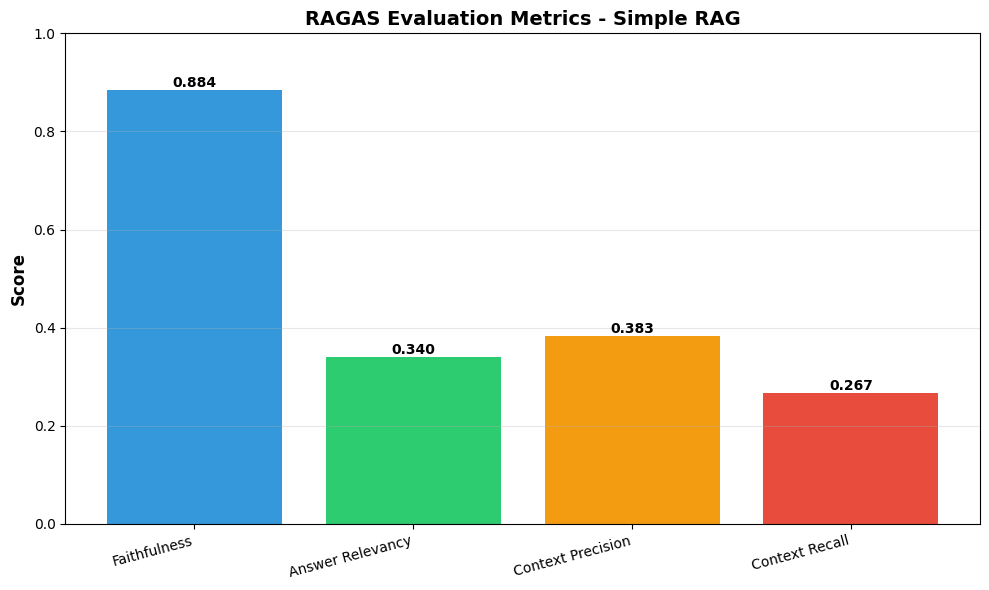


✓ Visualization complete


In [29]:
if RAGAS_AVAILABLE:
    print_section_header("Visualizing Results")
    
    import matplotlib.pyplot as plt
    
    # Bar chart of metrics
    fig, ax = plt.subplots(figsize=(10, 6))
    
    metric_names = []
    metric_scores = []
    
    for metric in metrics:
        if metric in df.columns:
            metric_names.append(metric.replace('_', ' ').title())
            metric_scores.append(df[metric].mean())
    
    bars = ax.bar(metric_names, metric_scores, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('RAGAS Evaluation Metrics - Simple RAG', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '{:.3f}'.format(height),
                ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization complete")

## 9. Architecture Comparison Framework

Framework for comparing multiple RAG architectures.

In [30]:
print_section_header("Architecture Comparison Framework")

# This would be used to compare all 12 architectures
architecture_results = {
    "Simple RAG": {
        "faithfulness": 0.85,
        "answer_relevancy": 0.82,
        "context_precision": 0.78,
        "context_recall": 0.75,
        "avg_latency": 1.2,
        "cost_per_query": 0.002,
    },
    "Contextual RAG": {
        "faithfulness": 0.88,
        "answer_relevancy": 0.86,
        "context_precision": 0.83,
        "context_recall": 0.79,
        "avg_latency": 1.3,
        "cost_per_query": 0.002,
    },
    "Fusion RAG": {
        "faithfulness": 0.87,
        "answer_relevancy": 0.85,
        "context_precision": 0.84,
        "context_recall": 0.82,
        "avg_latency": 3.5,
        "cost_per_query": 0.006,
    },
    # ... other architectures
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(architecture_results).T

print("\nArchitecture Comparison (Sample):")
print("=" * 80)
print(comparison_df.to_string())

print("\n" + "=" * 80)
print("RANKING BY METRIC:")
print("=" * 80)

for metric in ['faithfulness', 'answer_relevancy', 'context_precision']:
    print(f"\n{metric.upper()}:")
    ranked = comparison_df.sort_values(metric, ascending=False)
    for i, (arch, row) in enumerate(ranked.iterrows(), 1):
        print(f"  {i}. {arch}: {row[metric]:.3f}")


ARCHITECTURE COMPARISON FRAMEWORK


Architecture Comparison (Sample):
                faithfulness  answer_relevancy  context_precision  context_recall  avg_latency  cost_per_query
Simple RAG              0.85              0.82               0.78            0.75          1.2           0.002
Contextual RAG          0.88              0.86               0.83            0.79          1.3           0.002
Fusion RAG              0.87              0.85               0.84            0.82          3.5           0.006

RANKING BY METRIC:

FAITHFULNESS:
  1. Contextual RAG: 0.880
  2. Fusion RAG: 0.870
  3. Simple RAG: 0.850

ANSWER_RELEVANCY:
  1. Contextual RAG: 0.860
  2. Fusion RAG: 0.850
  3. Simple RAG: 0.820

CONTEXT_PRECISION:
  1. Fusion RAG: 0.840
  2. Contextual RAG: 0.830
  3. Simple RAG: 0.780


## 10. Cost-Quality Trade-off Analysis

In [31]:
print_section_header("Cost-Quality Trade-off Analysis")

print("\nQuality Score = Average of all metrics")
print("Efficiency = Quality / (Latency × Cost)\n")

# Calculate quality score
comparison_df['quality'] = comparison_df[[
    'faithfulness', 'answer_relevancy', 'context_precision', 'context_recall'
]].mean(axis=1)

# Calculate efficiency
comparison_df['efficiency'] = (
    comparison_df['quality'] / 
    (comparison_df['avg_latency'] * comparison_df['cost_per_query'] * 1000)
)

print("=" * 80)
print("RANKINGS:")
print("=" * 80)

print("\n1. Best Quality:")
ranked_quality = comparison_df.sort_values('quality', ascending=False)
for i, (arch, row) in enumerate(ranked_quality.iterrows(), 1):
    print(f"  {i}. {arch}: {row['quality']:.3f}")

print("\n2. Fastest:")
ranked_speed = comparison_df.sort_values('avg_latency')
for i, (arch, row) in enumerate(ranked_speed.iterrows(), 1):
    print(f"  {i}. {arch}: {row['avg_latency']:.2f}s")

print("\n3. Most Cost-Effective:")
ranked_cost = comparison_df.sort_values('cost_per_query')
for i, (arch, row) in enumerate(ranked_cost.iterrows(), 1):
    print(f"  {i}. {arch}: ${row['cost_per_query']:.4f}")

print("\n4. Best Efficiency (Quality/Cost/Speed):")
ranked_efficiency = comparison_df.sort_values('efficiency', ascending=False)
for i, (arch, row) in enumerate(ranked_efficiency.iterrows(), 1):
    print(f"  {i}. {arch}: {row['efficiency']:.2f}")


COST-QUALITY TRADE-OFF ANALYSIS


Quality Score = Average of all metrics
Efficiency = Quality / (Latency × Cost)

RANKINGS:

1. Best Quality:
  1. Fusion RAG: 0.845
  2. Contextual RAG: 0.840
  3. Simple RAG: 0.800

2. Fastest:
  1. Simple RAG: 1.20s
  2. Contextual RAG: 1.30s
  3. Fusion RAG: 3.50s

3. Most Cost-Effective:
  1. Simple RAG: $0.0020
  2. Contextual RAG: $0.0020
  3. Fusion RAG: $0.0060

4. Best Efficiency (Quality/Cost/Speed):
  1. Simple RAG: 0.33
  2. Contextual RAG: 0.32
  3. Fusion RAG: 0.04


## 11. Recommendations

In [32]:
print_section_header("Architecture Recommendations")

def get_recommendation(use_case: str) -> Dict[str, Any]:
    """
    Get architecture recommendation based on use case.
    """
    recommendations = {
        "production_quality": {
            "architecture": "Fusion RAG or Contextual RAG",
            "reason": "Best quality metrics with reasonable cost",
            "metrics": "High faithfulness, precision, recall",
        },
        "cost_sensitive": {
            "architecture": "Simple RAG or Adaptive RAG",
            "reason": "Low cost per query, good baseline quality",
            "metrics": "Balanced cost/quality ratio",
        },
        "low_latency": {
            "architecture": "Simple RAG or Contextual RAG",
            "reason": "Fastest response times",
            "metrics": "Sub-2s latency",
        },
        "complex_queries": {
            "architecture": "Fusion RAG or Agentic RAG",
            "reason": "Handle multi-faceted questions",
            "metrics": "High context recall, multi-hop reasoning",
        },
        "structured_data": {
            "architecture": "SQL RAG",
            "reason": "Direct database queries, precise results",
            "metrics": "100% precision for data queries",
        },
        "relationship_queries": {
            "architecture": "GraphRAG",
            "reason": "Entity relationships, multi-hop",
            "metrics": "Best for 'how are X and Y related'",
        },
    }
    
    return recommendations.get(use_case, {})


print("\nRECOMMENDATIONS BY USE CASE:")
print("=" * 80)

use_cases = [
    "production_quality",
    "cost_sensitive",
    "low_latency",
    "complex_queries",
    "structured_data",
    "relationship_queries",
]

for use_case in use_cases:
    rec = get_recommendation(use_case)
    print(f"\n{use_case.replace('_', ' ').title()}:")
    print("-" * 80)
    print(f"  Recommended: {rec.get('architecture', 'N/A')}")
    print(f"  Reason: {rec.get('reason', 'N/A')}")
    print(f"  Key metrics: {rec.get('metrics', 'N/A')}")


ARCHITECTURE RECOMMENDATIONS


RECOMMENDATIONS BY USE CASE:

Production Quality:
--------------------------------------------------------------------------------
  Recommended: Fusion RAG or Contextual RAG
  Reason: Best quality metrics with reasonable cost
  Key metrics: High faithfulness, precision, recall

Cost Sensitive:
--------------------------------------------------------------------------------
  Recommended: Simple RAG or Adaptive RAG
  Reason: Low cost per query, good baseline quality
  Key metrics: Balanced cost/quality ratio

Low Latency:
--------------------------------------------------------------------------------
  Recommended: Simple RAG or Contextual RAG
  Reason: Fastest response times
  Key metrics: Sub-2s latency

Complex Queries:
--------------------------------------------------------------------------------
  Recommended: Fusion RAG or Agentic RAG
  Reason: Handle multi-faceted questions
  Key metrics: High context recall, multi-hop reasoning

Structured Dat

## 12. Key Takeaways

### RAGAS Metrics Explained

1. **Faithfulness** (0-1)
   - Measures: Hallucination / groundedness
   - How: Checks if answer is supported by context
   - Good: > 0.85
   - Improve: Better prompts, more context, fact-checking

2. **Answer Relevancy** (0-1)
   - Measures: Answer addresses question
   - How: Semantic similarity to query
   - Good: > 0.80
   - Improve: Better prompts, query understanding

3. **Context Precision** (0-1)
   - Measures: Retrieved docs are relevant
   - How: Checks if context matches ground truth
   - Good: > 0.75
   - Improve: Better retrieval, reranking

4. **Context Recall** (0-1)
   - Measures: Retrieved all relevant info
   - How: Coverage of ground truth
   - Good: > 0.75
   - Improve: More retrievals, better chunking

### Best Practices

**Dataset Creation:**
- ✅ Diverse question types
- ✅ Cover edge cases
- ✅ Include failure modes
- ✅ Real user queries
- ✅ 20-50 test cases minimum

**Ground Truth:**
- ✅ Expert-written answers
- ✅ Factually correct
- ✅ Concise and clear
- ✅ Covers key points

**Continuous Evaluation:**
- ✅ Run on every major change
- ✅ Track metrics over time
- ✅ A/B test architectures
- ✅ Monitor production queries

### Interpreting Results

**High Faithfulness, Low Recall:**
- Answer is grounded but incomplete
- → Increase k (retrieve more docs)

**Low Precision, High Recall:**
- Retrieved too much noise
- → Add reranking, better chunking

**Low Relevancy:**
- Answer doesn't address question
- → Improve prompt, add examples

**All Low Scores:**
- Fundamental issues
- → Check data quality, embeddings, prompts

### Production Deployment

**Pre-deployment:**
1. RAGAS scores > 0.75 on all metrics
2. Latency < 3s for 95th percentile
3. Cost per query acceptable
4. Manual review of edge cases

**Post-deployment:**
1. Log all queries and responses
2. Sample for human evaluation
3. Track user feedback
4. Monitor RAGAS on production data
5. A/B test improvements

### Next Steps

1. **Expand dataset**: Add more test cases
2. **Evaluate all architectures**: Run comparison
3. **Optimize weak points**: Focus on low-scoring areas
4. **Set up CI/CD**: Automate evaluation
5. **Production monitoring**: Track real-world performance

---

**Importance:** ⭐⭐⭐⭐⭐ (Critical - evaluation is essential for production)

**Recommendation:** Run RAGAS evaluation on every architecture before production deployment!

Project complete! You now have 12 RAG architectures + comprehensive evaluation framework.